<a href="https://colab.research.google.com/github/pszwed-ai/lab-eksploracja-danych/blob/main/Psy_i_koty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Psy i koty 
... czyli klasyfikacja obrazów i manipulacja dużą ilością danych


---
## Imię i nazwisko

---


#13.1. Pobieramy dane

Załadujemy zbiór danych z kolekcji [TensorFlow Datasets](https://www.tensorflow.org/datasets). Zbiór jest widoczny jako obiekt klasy ```tf.data.Dataset``` zapewniającej funkcjonalność podobną do strumieni.  

Przy pierwszym uruchomieniu dane zostaną pobrane. Później będzie można je czytać wielokrotnie.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

# Jeżeli błąd pobierania
# setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
ds = tfds.load('cats_vs_dogs', split='train', batch_size=None,as_supervised=True)


Liczba obrazów to:

In [ ]:
len(ds)

23262

###13.1.1 Wyświetlmy przykładowe obrazy

Przed wyświetleniem zostaną przeskalowane do tych samych rozmiarów

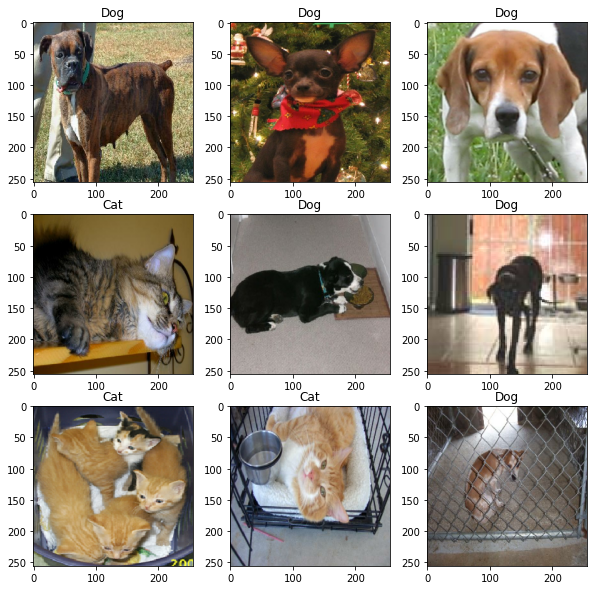

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
it = ds.as_numpy_iterator()
labels=['Cat','Dog']
input_size=100
for i in range(9):
  ax = plt.subplot(330 + 1 + i)
  image, label = next(it)
  image = tf.image.resize(image, size=[256,256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  ax.set_title(labels[label])
  plt.imshow(image)
plt.show()

###13.1.2 Załadujemy obrazy i zapiszemy w tablicach numpy

Obraz jest trójwymiarową tablicą (szerokość, wysokość, kanały koloru). Aby umieścić wszystkie obrazy w jednej tablicy 4D musza mieć identyczne rozmiary.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.image import img_to_array
from tqdm import tqdm

def load_images_to_numpy(name,resize_to=[100,100]):
  ds = tfds.load(name, split='train', batch_size=None,as_supervised=True)
  images = []
  labels=[]
  for image, label in tqdm(ds):
    image = tf.image.resize(image, size=resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = img_to_array(image)/255
    images.append(image)
    labels.append(label.numpy())

  # return images,labels
  X=np.array(images)
  y=np.array(labels)
  return X,y

X,y = load_images_to_numpy('cats_vs_dogs')

print(X.shape)
print(y.shape)


100%|██████████| 23262/23262 [01:03<00:00, 368.72it/s]


(23262, 100, 100, 3)
(23262,)


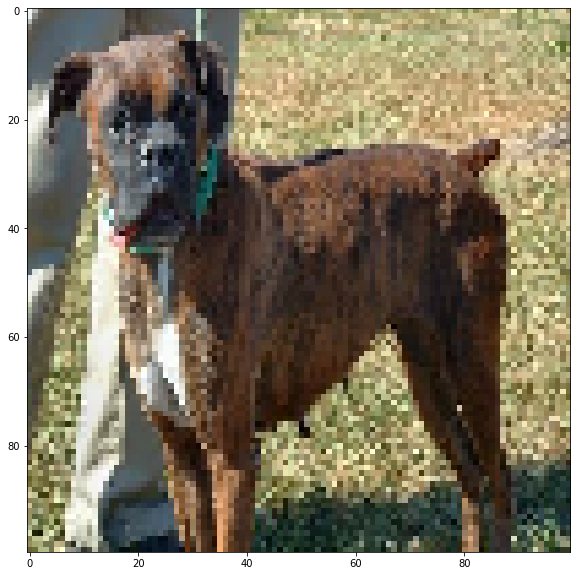

In [ ]:
plt.imshow(X[0]);

#13.2. Klasyfikacja zbioru załadowanego do pamięci

Wypróbujemy kilka klasyfiaktorów z biblioteki sklearn. Przedtem musimy spłaszczyć X do postaci dwuwymiarowej tablicy.

Nie oczekujemy tu dobrych wyników, ponieważ standardowe algorytmy traktują obraz, jak długi wektor pikeseli, a nie biorą pod uwagę cech lokalnych.

Gdyby przeskalować obraz do rozmiarów 4x4 otrzymalibyśmy informacje o kolorach w różnych regionach obrazu. Może pozwoliłoby to odróżnić krajobraz morski i lądowy, ale nie psy i koty.

In [ ]:
X = np.reshape(X,(X.shape[0],-1))
print(X.shape)

(23262, 30000)


**TODO 13.2.1**
* Wypróbuj wpierw GaussianNB, a potem co najmniej 3 wybrane kolejne klasyfikatory
* Jaka jest efektywność klasyfikacji? 
* Co się dzieje z pamięcią
* Zestaw informacje w postaci tabeli

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import sklearn

# clf = GaussianNB()
# clf = RandomForestClassifier(n_estimators=100,verbose=1)
# clf = MultinomialNB()
# clf = LogisticRegression()
clf = KNeighborsClassifier(n_neighbors=5)
# clf = SGDClassifier(loss='log')
# clf = SVC(kernel='rbf',gamma='auto')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy:{sklearn.metrics.accuracy_score(y_test,y_pred)}')
print(f'F1:{sklearn.metrics.f1_score(y_test,y_pred,average="macro")}')


#13.3. Partial fit

Zbiór wszystkich obrazów załadowany do pamięci zużywa około 30% pamięci środowiska Colab. Wydzielenie ```X_train``` i ```X_test``` to kolejne 30%. W przypadku niektórych klasyfikatorów brak jest miejsca na model...

W przypadku dużych zbiorów danych rozwiązanie może polegać na wykonaniu pętli, w której
* odczytuje się fragment danych (batch) ze źródła 
* dane te są uzyte do uczenia (uaktualnienia modelu)

W biblotece sklearn wybrane klasyfikatory i algorytmy regresji mają służącą do tego metodę ```partial_fit()```.

### 13.3.1 Organizacja odczytu danych

* Obrazy będą czytane z dysku
* Podczas odczytu dokonywana będzie konwersja za pomocą funkcji img_convert

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.image import img_to_array
from tqdm import tqdm

dataset = tfds.load('cats_vs_dogs', split='train', batch_size=None,as_supervised=True)


def img_convert(image,label):
  image = tf.image.resize(image, size=[100,100], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = image / 255
  return (image,label)


dataset = dataset.map(img_convert)
dataset = dataset.shuffle(buffer_size=100) 


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteAMCANZ/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


### 13.3.2 Podział na strumień danych uczących i testowych

Jest to podział sztywny. Funkcje take() i skip() przesuwają granice iteracji, ale nie zapewniają losowego wyboru.

Strumień (dataset) może losowo zmieniać kolejność danych, ale stosując bufor wewnętrzny o pewnym zadanym rozmiarze. 

In [ ]:
train_size = int(0.7*len(dataset))

ds_train = dataset.take(train_size)
ds_test = dataset.skip(train_size)
ds_test = ds_test.batch(256, drop_remainder=False)

print(len(ds_train),len(ds_test))
ds_train = ds_train.batch(128, drop_remainder=False)


16283 28


### 13.3.3 Iteracja po danych

In [ ]:
for batch,labels in  ds_train:
  X=batch.numpy()
  print(X.shape)
  
# Prosze wyczyścic wyjście...

### 13.3.4 Opcjonalnie: zawartość dataset może zostać zwielokrotniona

Można wówczas wielokrotnie iterować przez te same elementy. Wielokrotna iteracja ma sens, dla modeli wyznaczanych w procesie optymalizacji (np. za pomocą metod gradientowych.) Wówczas przy równoczensym zastosowaniu losowania  
możliwe jest opuszczenie minimum lokalnego funkcji kosztu.




In [ ]:
epochs=2
ds_train=ds_train.repeat(epochs)


### 13.3.5 Klasyfikacja

**TODO 13.3.1**
* Proszę wyznaczyć X na podstawie danych w zmiennej batch oraz y na podstawie labels. X nalezy spłaszczyć do tablicy 2-wymiarowej.
* Dla których (poniższych klasyfikatorów) wielokrotne przetwarzanie ('ogladanie') tych samych danych danych może mieć sens?
* Wypróbuj i porównaj dwa klasyfikatory implementujące metodę ```partial_fit()```. Jaka jest ich efektywność?

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier


from tqdm import tqdm

import sklearn

# clf = MultinomialNB()
# clf = GaussianNB()
# clf = PassiveAggressiveClassifier()
clf = SGDClassifier(loss='perceptron')


# for i,(batch,labels) in tqdm( enumerate(ds_train) ):
for i,(batch,labels) in enumerate(ds_train) :  
  X=batch.numpy()
  X = np.reshape(X,(X.shape[0],-1))
  y=labels.numpy()
  print(f'batch#{i} ({X.shape})')
  clf.partial_fit(X,y,classes=[0,1])

**TODO 13.3.2**
* Dodawaj do odpowiednich list oryginalne i przewidywane etykiety

In [ ]:
# predict

y_true_list=[]
y_pred_list=[]
for i,(batch,labels) in enumerate(ds_test):
  X=batch.numpy()
  X = np.reshape(X,(X.shape[0],-1))
  y=labels.numpy()
  print(f'batch#{i} ({X.shape})')
  y_pred = ???
  y_true_list.???
  y_pred_list.???



In [ ]:
y_true = np.hstack(y_true_list)
# y_true.shape

y_pred=np.hstack(y_pred_list)
# y_pred.shape

print(f'Accuracy:{sklearn.metrics.accuracy_score(y_true,y_pred)}')
print(f'F1:{sklearn.metrics.f1_score(y_true,y_pred,average="macro")}')
print(f'auroc:{sklearn.metrics.roc_auc_score(y_true,y_pred,average="macro")}')

Accuracy:0.521421407078378
F1:0.41338796130984734
auroc:0.523835908158765


### 13.3.6 Sprawdźmy metryki dla zbioru uczącego



In [ ]:
y_true_list=[]
y_pred_list=[]
for i,(batch,labels) in enumerate(ds_train):
  X=batch.numpy()
  X = np.reshape(X,(X.shape[0],-1))
  y=labels.numpy()
  print(f'batch#{i} ({X.shape})')
  y_pred = clf.predict(X)
  y_true_list.append(y)
  y_pred_list.append(y_pred)

y_true = np.hstack(y_true_list)
# y_true.shape

y_pred=np.hstack(y_pred_list)
y_pred.shape

print(f'Accuracy:{sklearn.metrics.accuracy_score(y_true,y_pred)}')
print(f'F1:{sklearn.metrics.f1_score(y_true,y_pred,average="macro")}')
print(f'auroc:{sklearn.metrics.roc_auc_score(y_true,y_pred,average="macro")}')

batch#0 ((128,))
batch#1 ((128,))
batch#2 ((128,))
batch#3 ((128,))
batch#4 ((128,))
batch#5 ((128,))
batch#6 ((128,))
batch#7 ((128,))
batch#8 ((128,))
batch#9 ((128,))
batch#10 ((128,))
batch#11 ((128,))
batch#12 ((128,))
batch#13 ((128,))
batch#14 ((128,))
batch#15 ((128,))
batch#16 ((128,))
batch#17 ((128,))
batch#18 ((128,))
batch#19 ((128,))
batch#20 ((128,))
batch#21 ((128,))
batch#22 ((128,))
batch#23 ((128,))
batch#24 ((128,))
batch#25 ((128,))
batch#26 ((128,))
batch#27 ((128,))
batch#28 ((128,))
batch#29 ((128,))
batch#30 ((128,))
batch#31 ((128,))
batch#32 ((128,))
batch#33 ((128,))
batch#34 ((128,))
batch#35 ((128,))
batch#36 ((128,))
batch#37 ((128,))
batch#38 ((128,))
batch#39 ((128,))
batch#40 ((128,))
batch#41 ((128,))
batch#42 ((128,))
batch#43 ((128,))
batch#44 ((128,))
batch#45 ((128,))
batch#46 ((128,))
batch#47 ((128,))
batch#48 ((128,))
batch#49 ((128,))
batch#50 ((128,))
batch#51 ((128,))
batch#52 ((128,))
batch#53 ((128,))
batch#54 ((128,))
batch#55 ((128,))
ba

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

[[4345 3810]
 [3077 5051]]


#13.4. Sieć neuronowa

Zbudujemy prostą sieć neuronową korzystającą z komponentów platformy TensorFlow/keras. Sieć składa się z: 
* warstwy wejściowej (takiej jak rozmiary obrazu, czyli [100,100,3])
* warstwy spłaszczającej do postaci wektora [300000]
* warstwy ukrytej liczącej 100 neuronów z funkjcą aktywacji [relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
* warstwy wyjściowej z dwoma neuronami i funkcją aktywacji [softmax](https://en.wikipedia.org/wiki/Softmax_function)

>Liczba neuronów wyjściowych odpowiada liczbie klas. Odczytujemy z nich prawdopodobieństwo i wybieramy większe z nich. 

>Alternatywna konfiguracja w przypadku klasyfikacji binarnej to jeden neuron wyjściowy z funkcją aktywacji sigmoid. Przypomina to regresję logistyczną. W takim przypadku wybieramy 0 dla prawdopodobieństwa p < 0.5 oraz 1 dla p>=0.5.   

>Funkcją kosztu jest *crossentropy* - odpowiednik *logloss* znanej z regresji logistycznej. 

> **Uwaga** Podobnie jak zwykłe klasyfikatory - to nie jest architektura odpowiednia do klasyfikacji obrazów. 


In [ ]:
from keras.layers import Input, Dense, Flatten
from keras import Model

def model_builder(input_shape,labels_count):
  model_input = Input(input_shape)
  x= Flatten()(model_input)
  x = Dense(input_shape[1],activation = 'relu')(x)
  x = Dense(labels_count,activation='softmax')(x)
  model = Model(model_input, x, name='simple')
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'] )
  return model

model = model_builder((100,100,3),2)


Wyświetlmy informacje o modelu. Ma dużo parametrów, ponad 3 000 000. 

Wejście ma rozmiar [None, 100, 100, 3] Podczas uczenia to None zostanie zastąpione wymiarami wsadu batch (tu 128).

Model: "simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3000100   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 3,000,302
Trainable params: 3,000,302
Non-trainable params: 0
_________________________________________________________________



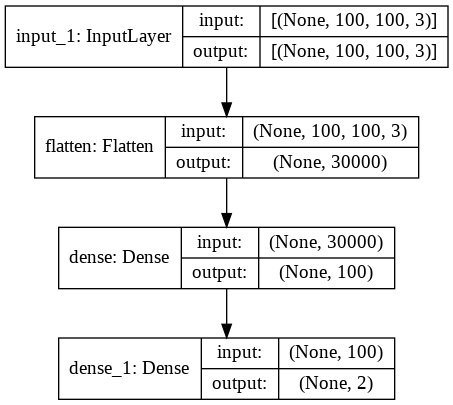

In [ ]:
from keras.utils import plot_model

model.summary()
print()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png',width = 1000, height = 1000)

Uczymy sieć.

* Każda epoka to jednokrotna iteracja po zbiorze danych. 
* Podział na wsady (batch) jest automatycznie dokonywany przez strumień 
* Podczas czytania batcha kolejne obrazy zostaną załadowane z dysku, przeskalowane i umieszczone w pamięci
* Mniej więcej w podobnym czasie poprzedni batch powinien być przetworzony na GPU 
* Po każdej epoce następuje walidacja na zbiorze testowym. To przedłuża czas przetwarzania epoki (ale umożliwia przygotowanie wykresów)
* Niestety kazda epoka trwa około 37-38 sekund

In [ ]:
history = model.fit(ds_train, epochs=20, batch_size=128,verbose=1,validation_data=ds_test)

Epoch 1/20
128/128 [==============================] - 42s 304ms/step - loss: 3.0737 - accuracy: 0.5231 - val_loss: 0.7275 - val_accuracy: 0.5638
Epoch 2/20
128/128 [==============================] - 37s 292ms/step - loss: 0.7491 - accuracy: 0.5485 - val_loss: 0.6593 - val_accuracy: 0.6134
Epoch 3/20
128/128 [==============================] - 38s 294ms/step - loss: 0.7342 - accuracy: 0.5674 - val_loss: 0.7739 - val_accuracy: 0.5433
Epoch 4/20
128/128 [==============================] - 37s 292ms/step - loss: 0.8254 - accuracy: 0.5532 - val_loss: 0.6614 - val_accuracy: 0.6085
Epoch 5/20
128/128 [==============================] - 37s 292ms/step - loss: 0.6904 - accuracy: 0.5961 - val_loss: 0.6809 - val_accuracy: 0.5981
Epoch 6/20
128/128 [==============================] - 37s 291ms/step - loss: 0.6845 - accuracy: 0.6013 - val_loss: 0.6739 - val_accuracy: 0.5901
Epoch 7/20
128/128 [==============================] - 37s 291ms/step - loss: 0.6757 - accuracy: 0.6084 - val_loss: 0.7781 - val_ac

**TODO 13.4.1** 
* Wyświetl wykresy z danymi zawartymi w history


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


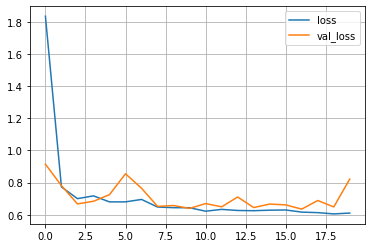

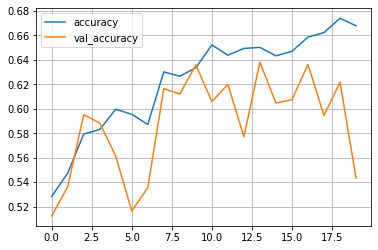

In [ ]:
print(history.history.keys())
plt.plot(???)
plt.plot(????)
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(????)
plt.plot(????)
plt.legend()
plt.grid()
plt.show()


#13.5. Zbiór danych w pamieci

Spróbujemy przetwarzać zbiór danych w pamięci. To powinno przyspieszyć. Colab ma słabe CPU i kod wykonywany po stronie hosta działa wolno.

### 13.5.1 Funkcja ładująca zbiór danych do macierzy numpy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.preprocessing.image import img_to_array
from tqdm import tqdm

def load_images_to_numpy(name,resize_to=[100,100]):
  ds = tfds.load('cats_vs_dogs', split='train', batch_size=None,as_supervised=True)
  images = []
  labels=[]
  for image, label in tqdm(ds):
    image = tf.image.resize(image, size=resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = img_to_array(image)/255
    images.append(image)
    labels.append(label.numpy())

  # return images,labels
  X=np.array(images)
  y=np.array(labels)
  return X,y


100%|██████████| 23262/23262 [01:19<00:00, 291.24it/s]


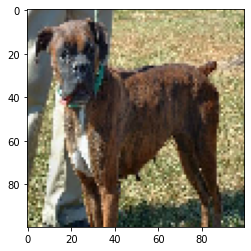

In [ ]:
X,y = load_images_to_numpy('cats_vs_dogs')
plt.imshow(X[0]);

### 13.5.2 Sprawdzamy ile mamy pamięci

In [ ]:
import psutil
psutil.virtual_memory()

svmem(total=13624655872, available=8706797568, percent=36.1, used=11481329664, free=152715264, active=5750628352, inactive=7349944320, buffers=17186816, cached=1973424128, shared=15929344, slab=149766144)

### 13.5.3 Duża monolityczna funkcja do ucznia modeli i ich oceny

Napiszemy funkcję, która:
1. Wydzieli zbiór uczący i testowy
2. Wywoła zewnętrzną funkcję do budowy modelu
3. Przeprowadzi uczenie z  walidacją
4. Przetestuje model na zbiorze testowym
5. Wypisze metryki


**TODO 13.5.1**
* Ad 1. Podziel dane w proporcjach określonych przez test_size za pomocą train_test_split
* Ad 3. Wywołaj model.fit
* Ad 3. Wyświetl historię
* Ad 4. Wyznacz przewidywane etykiety y_pred
* Ad 5. Oblicz metryki

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
import psutil

def split_train_test(X,y,model_builder,
                     epochs=20,
                     test_size=0.3, 
                     batch_size=128,
                     use_validation_data=True,
                     display_history=True):
  print(psutil.virtual_memory())
  X_train, X_test, y_train, y_test = ????
  
  
  ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000)
  ds_train = ds_train.batch(batch_size, drop_remainder=True)

  ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
  # ds_test = ds_test.batch(batch_size, drop_remainder=True)
  ds_test = ds_test.batch(batch_size)

  model = model_builder()
  validation_data=None
  if use_validation_data:
    validation_data = ds_test
  history = model.fit(?????)

  if display_history:
    ????
    plt.show()

    plt.figure()
    ?????
    plt.show()
  
  ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
  ds_test = ds_test.batch(128, drop_remainder=False)

  predict_proba = model.predict(????)
  print(predict_proba.shape)
  y_pred = ????


  print(f'acc={????}')
  print(f'prec={????}')
  print(f'recall={????}')
  print(f'f1={????}')
  
  print(psutil.virtual_memory())
  return model


### 13.5.4 Wywołanie

svmem(total=13624647680, available=9491611648, percent=30.3, used=7310213120, free=3662323712, active=4212539392, inactive=5392646144, buffers=45719552, cached=2606391296, shared=11821056, slab=145260544)
Epoch 1/20
127/127 [==============================] - 7s 30ms/step - loss: 3.1092 - accuracy: 0.5219 - val_loss: 0.6959 - val_accuracy: 0.5472
Epoch 2/20
127/127 [==============================] - 3s 27ms/step - loss: 0.7328 - accuracy: 0.5463 - val_loss: 0.7866 - val_accuracy: 0.5196
Epoch 3/20
127/127 [==============================] - 3s 27ms/step - loss: 0.6911 - accuracy: 0.5752 - val_loss: 0.7352 - val_accuracy: 0.5355
Epoch 4/20
127/127 [==============================] - 3s 27ms/step - loss: 0.6847 - accuracy: 0.5896 - val_loss: 0.6646 - val_accuracy: 0.5995
Epoch 5/20
127/127 [==============================] - 4s 27ms/step - loss: 0.6618 - accuracy: 0.6048 - val_loss: 0.7101 - val_accuracy: 0.5572
Epoch 6/20
127/127 [==============================] - 3s 27ms/step - loss: 0.666

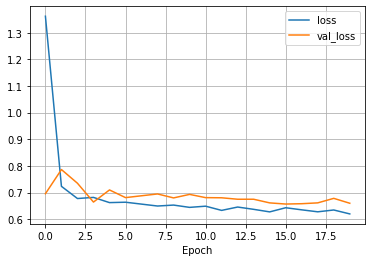

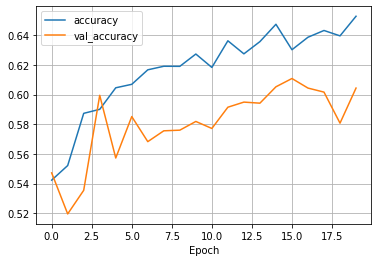

(6979, 2)
acc=0.6043845823183838
prec=0.6075820408509196
recall=0.6042460608808056
f1=0.6012374767034365
svmem(total=13624647680, available=6583611392, percent=51.7, used=11318300672, free=169840640, active=7252758528, inactive=5837213696, buffers=40239104, cached=2096267264, shared=13922304, slab=145010688)


In [ ]:
m =  split_train_test(X,y,lambda: model_builder((100,100,3),2))

**TODO 13.5.2**
* Oceń zużycie pamięci
* Czy pamięć została zwolniona po wyjściu z funkcji?

#13.6. Konwolucyjna sieć neuronowa CNN

* Sieci konwolucyjne automatycznie ekstrahują cechy z obrazu stosując operacje  konwolucji.
* Nie posługują się ustalonymi manualnie wagami filtrów konwolucji, ale wyznaczają je w trakcie uczenia

Zaprezentowane tu modele pochodzą ze strony [How to Classify Photos of Dogs and Cats (with 97% accuracy)](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/) ale zostały nieco zmodyfikowane

* Rozmiary obrazów sa mniejsze (100 x 100) vs (224 x 224). Zapewne wyniki będa gorsze
* Zastosowane sa modele z dwoma neuronami wyjściowym



### 13.6.1 Prosty model

In [ ]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras import Sequential
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model


def define_simple_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(2, activation='softmax'))
	# compile model
	model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
	return model

model = define_simple_model()


#### Inspekcja modelu

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               10240128  
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 258       
Total params: 10,241,282
Trainable params: 10,241,282
Non-trainable params: 0
_________________________________________________________________



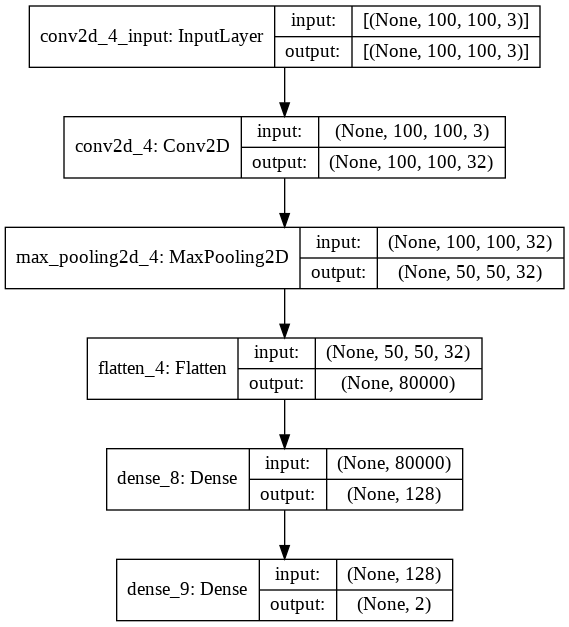

In [ ]:
from keras.utils import plot_model

model.summary()
print()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png',width = 1000, height = 1000)

#### Uczenie i ocena

svmem(total=13624647680, available=9447256064, percent=30.7, used=7330369536, free=326725632, active=4177039360, inactive=8604872704, buffers=91222016, cached=5876330496, shared=11726848, slab=295182336)
Epoch 1/20
127/127 [==============================] - 39s 50ms/step - loss: 4.2622 - accuracy: 0.5359 - val_loss: 0.5977 - val_accuracy: 0.6790
Epoch 2/20
127/127 [==============================] - 5s 43ms/step - loss: 0.5749 - accuracy: 0.6997 - val_loss: 0.5692 - val_accuracy: 0.6987
Epoch 3/20
127/127 [==============================] - 5s 42ms/step - loss: 0.5064 - accuracy: 0.7535 - val_loss: 0.5317 - val_accuracy: 0.7345
Epoch 4/20
127/127 [==============================] - 5s 41ms/step - loss: 0.4740 - accuracy: 0.7726 - val_loss: 0.5733 - val_accuracy: 0.7126
Epoch 5/20
127/127 [==============================] - 5s 42ms/step - loss: 0.4567 - accuracy: 0.7759 - val_loss: 0.5369 - val_accuracy: 0.7392
Epoch 6/20
127/127 [==============================] - 5s 42ms/step - loss: 0.377

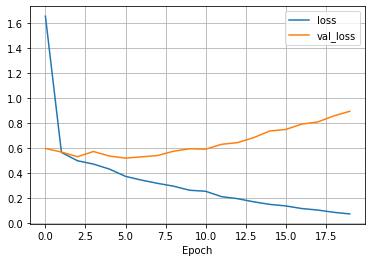

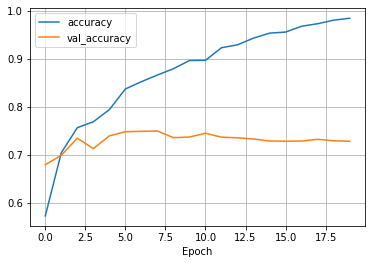

(6979, 2)
acc=0.7278979796532454
prec=0.728878648233487
recall=0.7278455855420816
f1=0.7275758121349695
svmem(total=13624647680, available=5456408576, percent=60.0, used=10790760448, free=162250752, active=8101449728, inactive=4966694912, buffers=39452672, cached=2632183808, shared=15925248, slab=167096320)


In [ ]:
m =  split_train_test(X,y,define_simple_model,epochs=20)

### 13.6.2 Zaawansowany model korzystjący z tarnsfer learning



In [ ]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras import Sequential
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Na podstawie
# https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

def define_vgg16_model():
	# load model
	model = VGG16(include_top=False, input_shape=(100, 100, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(2, activation='softmax')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
	return model

model = define_vgg16_model()

58892288/58889256 [==============================] - 0s 0us/step


#### Inspekcja modelu

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

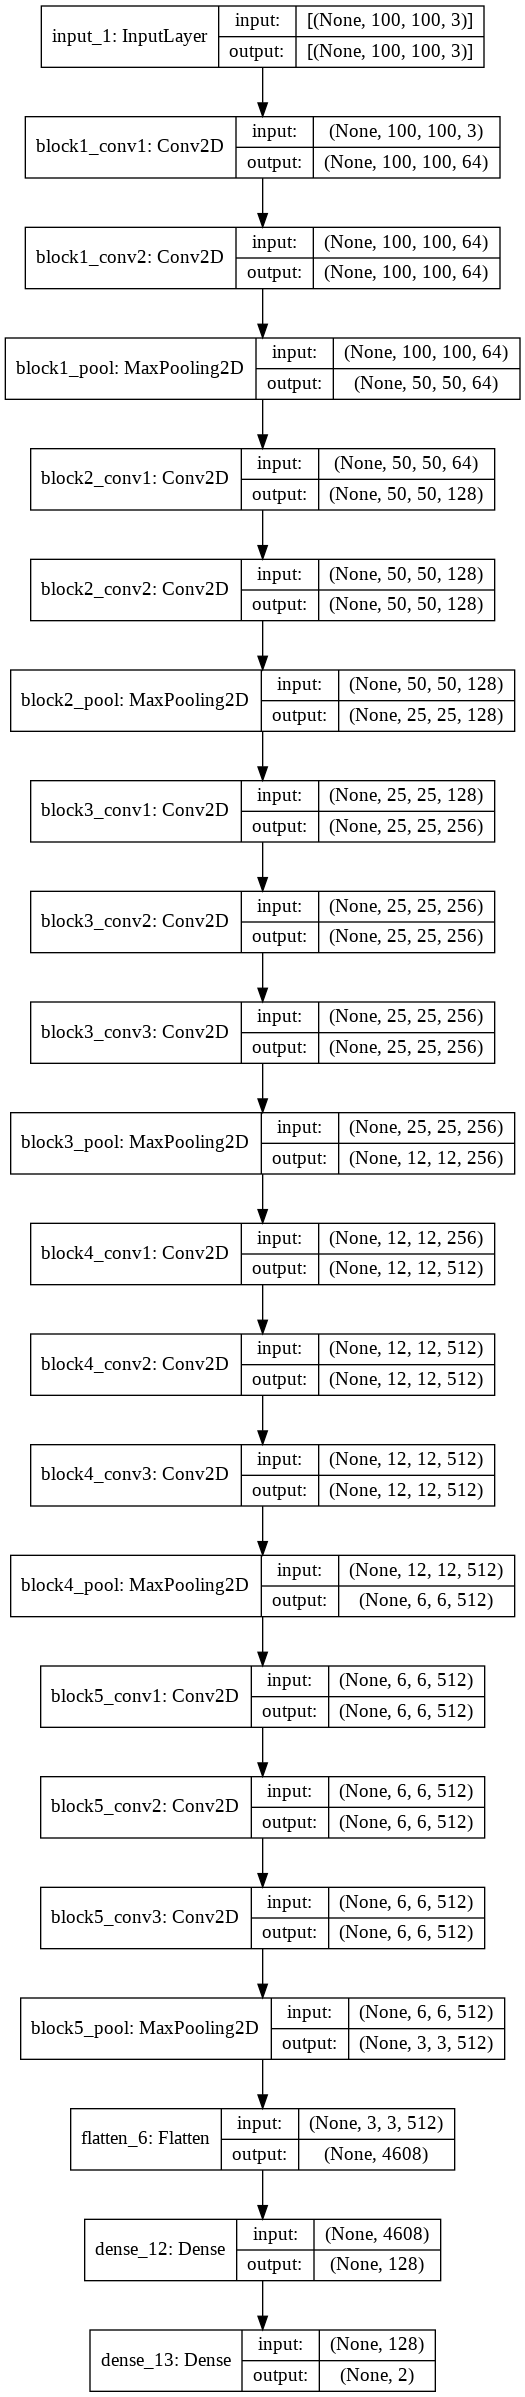

In [ ]:
from keras.utils import plot_model

model.summary()
print()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png',width = 1000, height = 1000)

#### Uczenie i ocena

svmem(total=13624655872, available=8720261120, percent=36.0, used=11575672832, free=183513088, active=6862446592, inactive=6200324096, buffers=19210240, cached=1846259712, shared=15929344, slab=149716992)
Epoch 1/20
127/127 [==============================] - 28s 182ms/step - loss: 0.7154 - accuracy: 0.7201 - val_loss: 0.3147 - val_accuracy: 0.8646
Epoch 2/20
127/127 [==============================] - 21s 162ms/step - loss: 0.2961 - accuracy: 0.8681 - val_loss: 0.2880 - val_accuracy: 0.8756
Epoch 3/20
127/127 [==============================] - 21s 164ms/step - loss: 0.2685 - accuracy: 0.8834 - val_loss: 0.2900 - val_accuracy: 0.8766
Epoch 4/20
127/127 [==============================] - 21s 165ms/step - loss: 0.2485 - accuracy: 0.8939 - val_loss: 0.2946 - val_accuracy: 0.8739
Epoch 5/20
127/127 [==============================] - 21s 166ms/step - loss: 0.2250 - accuracy: 0.9051 - val_loss: 0.2833 - val_accuracy: 0.8765
Epoch 6/20
127/127 [==============================] - 21s 167ms/step -

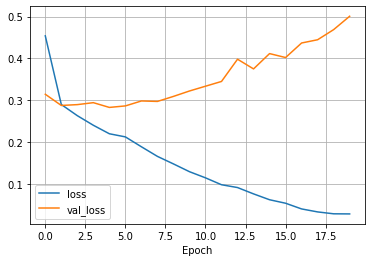

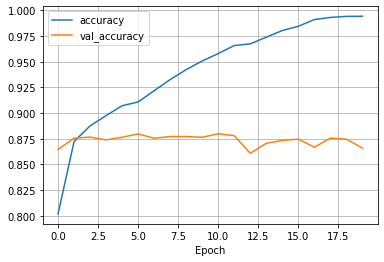

(6979, 2)
acc=0.8658833643788508
prec=0.8681157138713349
recall=0.8658220534829977
f1=0.8656655866189241
svmem(total=13624655872, available=8519708672, percent=37.5, used=11568046080, free=145682432, active=7127236608, inactive=5972840448, buffers=19349504, cached=1891577856, shared=15929344, slab=150458368)


In [ ]:
m =  split_train_test(X,y,define_vgg16_model,epochs=20)

### 13.6.3 Zobaczmy koty i psy...

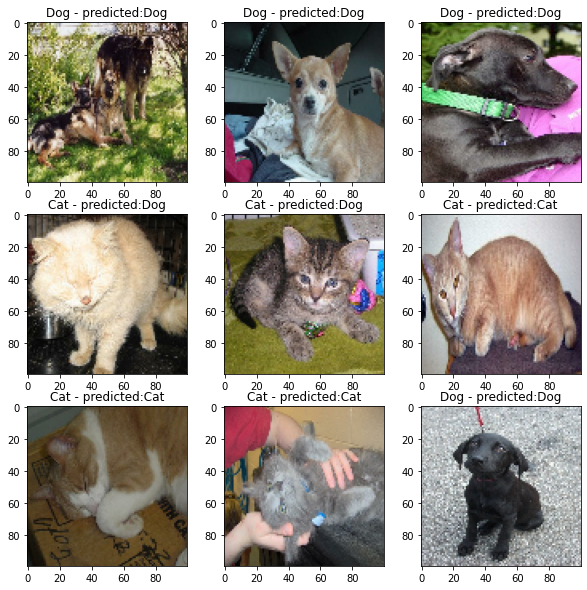

In [ ]:
ds = tfds.load('cats_vs_dogs', split='train', batch_size=None,as_supervised=True).shuffle(1000)
it = ds.as_numpy_iterator()
plt.rcParams["figure.figsize"] = (10,10)
labels=['Cat','Dog']
input_size=100
for i in range(9):
  ax = plt.subplot(330 + 1 + i)
  image, label = next(it)
  image = tf.image.resize(image, size=[100,100], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  batched_image = tf.expand_dims(image, axis=0)
  pp = m.predict(batched_image)
  c = np.argmax(pp)
  ax.set_title(labels[label]+" - predicted:"+labels[c])
  ax.imshow(image)
plt.show()



**TODO 13.6.1**
* Przeanalizuj wykresy. Ile epok wystarczyło wybrać?
* Jak zmienia się wartość funkcji kosztu i trafność dla zbioru uczącego?
* Jak scharakteryzujesz sytuację począwszy od 5-6 epoki?

### 13.6.4 Twój model

**TODO 13.6.2**
* Wybierz jeden z modeli ze strony [How to Classify Photos of Dogs and Cats (with 97% accuracy)](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/) 
* Dostosuj analogicznie do innej reprezentacji wyjścia (2 neurony)
* Wyświetl strukture
* Przeprowadź uczenie i ocenę

### Inspekcja modelu

### Uczenie i ocena

**TODO 13.6.3**
* Porównaj złożoność wybranego modelu z innymi i skomentuj wyniki